# Interaction Elémentaire

## Création d'un scatter plot interactif

### Visualisation des abondances et Pathway pour chaque protéine

Nous allons représenter la relation entre l'abondance des protéines (**Log2 Corrected Abundance Ratio**)  et la précision de la mesure (**LOG10 Adj.P-val**).

In [1]:
import sys, os
workDir = f"{os.getcwd()}/.."
libDir = f"{workDir}/lib"
dataDir= f"{workDir}/../data" 

sys.path.append(libDir)

In [2]:
import pandas
import numpy as np
# We use notebook backend to have interactivity support
%matplotlib notebook 

import matplotlib.pyplot as plt

* Owlready2 * Warning: optimized Cython parser module 'owlready2_optimized' is not available, defaulting to slower Python implementation


#### Exemple pour commencer
Observer la cellule suivante qui illustre la construction d'un scatter plot et des améliorations possibles.

###### Creation du scatter plot
[matplotlib.axes.Axes.scatter()](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.scatter.html) permet d'intialiser le graphique.
Les quatre arguments positionnels suivants peuvent être donnés:
```python
Axes.scatter(x,      # Les coordonnées X des points: Float[]
             y,      # Les coordonnées Y des points: Float[]
             radius, # Les rayons des points       : Float[] | Float 
             color   # Les couleurs des points     : ColorSymbol[] | ColorSymbol
```
Bien sûr, seuls les deux premiers sont obligatoires, `radius` et `color` étant dotés de valeurs par défault. Si une seule valeur est passée à `radius` ou `color`, elle sera appliqué uniformément à tous les points. 

###### Modification continue du scatter plot
Mais cette fonction retourne aussi un objet [PathCollection](https://matplotlib.org/3.1.1/api/collections_api.html) qui permet de modifier à posteriori le rendu des points du scatter plot.
###### Interactivité
L'affichage d'une figure via la méthode `fig.canvas.mpl_connect('EVENT_NAME', callbackFunction)` permet d'associer à [un évenement sur la figure](https://matplotlib.org/3.1.1/users/event_handling.html) l'execution du fonction (*callbackFunction*). 

A partir de matplotlib 3.5.0, on lui préferera la fonction [connect_event()](https://matplotlib.org/stable/api/widgets_api.html?highlight=mpl_connect))

</br><span style="color:green; font-weight:bold">$\downarrow$ Illustration ci-dessous $\downarrow$</span>
</br><span style="color:green;"> NB: Pour l'instant nous passons une liste de nombres aléatoires comme argument "couleur" et matplotlib créé pour nous une palette de couleurs. Nous verrons plus tard comment **choisir notre palette de couleurs**.</span>

<IPython.core.display.Javascript object>


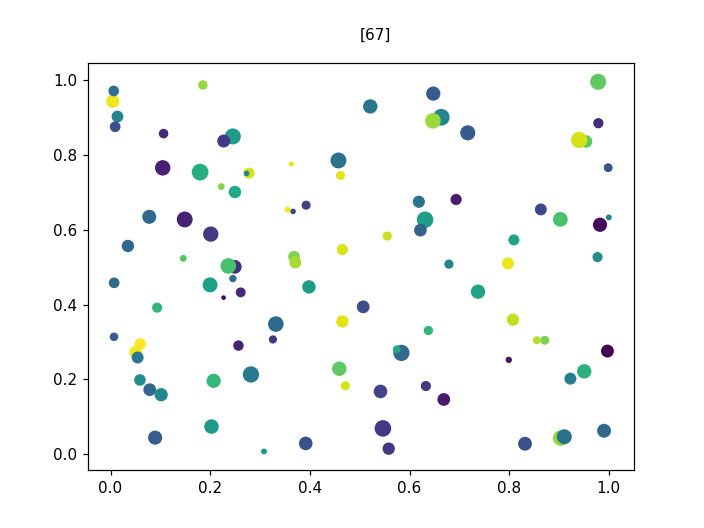

In [19]:
x, y, c, s = np.random.rand(4, 100)

def onclick(event):
    tx = 'button=%d, x=%d, y=%d, xdata=%f, ydata=%f' % (event.button, event.x, event.y, event.xdata, event.ydata)
    text.set_text(tx)
    path_collection.set_sizes( np.random.rand(100) * 100 )
    
def onpick(event):
    ind = event.ind
    tx = str(ind)
    text.set_text(tx)
    path_collection.set_sizes( np.random.rand(100) * 100 )
    
fig = plt.figure()
ax1 = fig.add_subplot(111)
path_collection = ax1.scatter(x, y, 100*s, c, picker=True)
text = ax1.text(0.5,1.1, "", va="bottom", ha="left")

#cid = fig.canvas.mpl_connect('button_press_event', onclick)
cid = fig.canvas.mpl_connect('pick_event', onpick)

#### Exercice1: Volcano plot interactif

<br/><span style="color:firebrick;font-weight:bold">$\rhd$ Lecture des données à partir du TSV 
 comme dans le TP précédent</span>
 <br/><span style="color:firebrick;font-weight:bold">$\rhd$ Dessiner un volcano plot qui affichera via <a href="https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.text.html">Axes.text</a> le nom de la protéine cliquée</span>
 
<span style="color:green">NB : Comme illustré ci-dessus, le paramètre event possède un attribut *ind* qui est l'indice de l'élément cliqué.</span>
</br><span style="color:green">$\downarrow$ Vous pouvez faire une figure à deux axes: le premier détenant le scatter-plot et le deuxième axe n'affichant que le nom de la protéine cliquée</span>

#### Exercice2: Volcano plot avancé
Dans un nouvelle figure, choisissez une des fonctionnalités suivantes à implémenter:
* Colorier les protéines des n Pathways les plus représentés dans le namespace GO de votre choix (biological_process, molecular function, cellular component): **utiliser des palettes de couleurs catégorielles**. Pour une protéine, la priorité sera donnée au pathway avec la meilleur p-value.
* Dessiner un volcano plot qui coloriera d'une même couleur les protéines appartenant au pathway GO de la protéine clickée
* Dessiner un volcano plot qui fera disparaitre les protéines n'appartenant pas au même pathway(s) GO que ceux de la protéine clickée

<span style="color:green;font-weight:bold">$\downarrow$ Parcourez l'aide ci-dessous avant de choisir$\downarrow$</span>

### <span style="color:green">Rappel et guide: Palettes de couleurs</span>
matplotlib propose une variété de [palettes de couleurs](https://matplotlib.org/stable/tutorials/colors/colormaps.html).
##### Divergentes ou Séquentielles
![caption](../figs/cmap1.png)
![caption](../figs/cmap2.png)
##### Continues ou Catégorielles
![caption](../figs/cmap4.png)
##### Cyclique
![caption](../figs/cmap3.png)

<br/><span style="color:firebrick;font-weight:bold">$\rhd$ Quel type de palette choisir pour colorier en fonction:</span>
* <span style="color:firebrick">Des pathways ?</span>
* <span style="color:firebrick">Des pvalues ? </span>

### <span style="color:green">API colormap</span>
###### Charger une palette de couleurs
```python
cmap = plt.get_cmap('Paired')
```

###### Palettes de couleurs catégorielles
Elles proposent des valeurs discrètes organisées en une liste de triplets RGB
###### Connaitre son nombre d'éléments
```python
print(cmap.N)
```
###### Accéder à sa liste de couleurs
```python
print(cmap.colors)
```
###### Exemple
![caption](../figs/cmap5.png)

##### Palettes de couleurs quantitatives
Elles proposent des valeurs de couleurs continues.

Il s'agit de fonctions prenant une valeur en entrée et retournant un triplet RGB. Par défault le domaine de cette fonction est $[0, 1]$. L'intervalle est "cyclique", (1.2 donne 0.2, -1.5 donne 0.5, etc).

Dans la pratique on devra donc normaliser les valeurs à colorer, pour qu'elles soient contenues dans l'intervalle $[0, 1]$. Deux questions se posent alors pour définir cette fonction $f$:
* Les bornes min et max de l'intervalle des valeurs à colorer, telles que $f(min) = 0, f(max) = 1$
* L'interpolation pour determiner les valeurs intermédiaires, les plus usuelles étant:
    * Linéaire
    * Logarithmique
    
**Le module [colors](https://matplotlib.org/3.1.1/api/colors_api.html) fournit deux outils suivants**

###### Fonctions de normalisation 
![caption](../figs/cmap6.png)
###### Fonctions de couleur
![caption](../figs/cmap7.png)

###### Exemples avec la palette HSV
* Colorations avec **normalisation linéaire**, **normalisation logarithmique**, **normalisation logarithmique explicite**
![caption](../figs/cmap8.png)

<br/><span style="color:firebrick;font-weight:bold">$\rhd$ Lecture des données à partir du TSV 
 comme dans le TP précédent</span>
 <br/><span style="color:firebrick;font-weight:bold">$\rhd$ Analyse ORA via <i>stat_utils.GO_ORA_analyser</i> OU lecture de données ORA via les fichiers  <i>data/ora/*.json</i></span>
 <br/><span style="color:firebrick;font-weight:bold">$\rhd$ Construction du volcano-plot avancé choisi </span>